### Class 02 - Example

In this notebook, I will run you through the steps required to perform the exercise for class 2.
Here is a reminder of the instructions:
1. Create a folder called `group-x` within `nbs/class_02`, cd into it and work within that today
2. First, go back to your notebooks from last week, to remind yourself of what the data looks like
3. Secondly, choose which outcome variable you want to model. On the basis of this, define **which evaluation metric** could be suitable, and choose one:
    - We have mentioned metrics like RMSE, MAE, R-squared for regression
    - For classification, metrics like accuracy, precision/recall, or F1 scores will be relevant
    - All "classical" metrics can be computed using scikit-learn, if you don't want to implement them yourself;
4. (a) If you are in the bike sharing group, split your dataset into a training/validation/test set using later time points as validation/test set. Validation and test set should be 15% of your data each. (b) If you are in the personality group, using sklearn's `train_test_split` function, create a 75/15/15 random split of your data.
    - Remember to set a seed (`random_state`) when you do so. Let's all use the same (the classic `random_state=42`)
    - Save these datasets as separate csv files in a subfolder called `data`
5. Look at your outcome variable: do you want to transform it in any way?
5. Estimate the performance of your dummy baselines on all splits
6. Now look at your predictors: do they need any preprocessing? Any transformations? Removal of "bad" data points?
7. Fit your incremental models using KKN (sklearn's `KNeighborsRegressor`: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) or linear models (`LinearRegressor`: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Save the fitted model object (with a meaningful name) using `pickle` (https://scikit-learn.org/stable/model_persistence.html) in a subfolder called `model`.
8. Once you are done, evaluate all models on both the training and the validation set
9. Bonus: if you have time, try to visualize if any pattern emerges


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

First, let's load a dataset and do some basic data visualization. Our toy dataset includes 10 predictors (age, sex, body mass index, average blood pressure, and six blood serum measurements) for 442 diabetes patients. The outcome variable (which we code as "target") is a quantitative measure of disease progression. You can read more here: https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

In [4]:


data = datasets.load_diabetes(as_frame=True)['data']
data['target'] = datasets.load_diabetes(as_frame=True)['target']

Let's get some information abouts this dataset

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


All our variables are numerical. Let's get a sense for what their range is.

In [6]:
data.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


In [7]:
data.sex.unique()

array([ 0.05068012, -0.04464164])

Let's take a look at the distribution of our outcome variable.

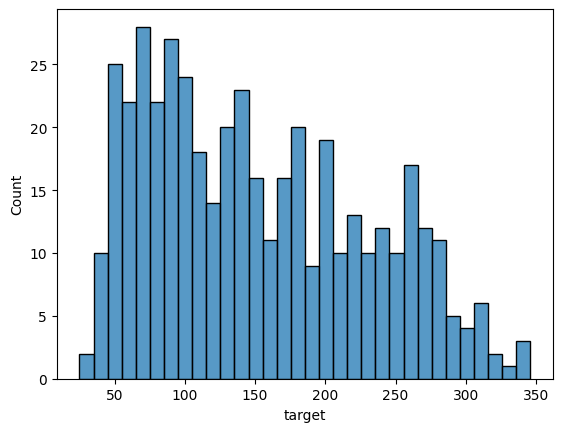

In [8]:
sns.histplot(data=data, x='target', binwidth=10)
plt.show()

Judging from the mean values, all predictors have been standardized, but our target variable has not. Let's take a look at the correlation structure of the dataset and at potential relations between predictors.

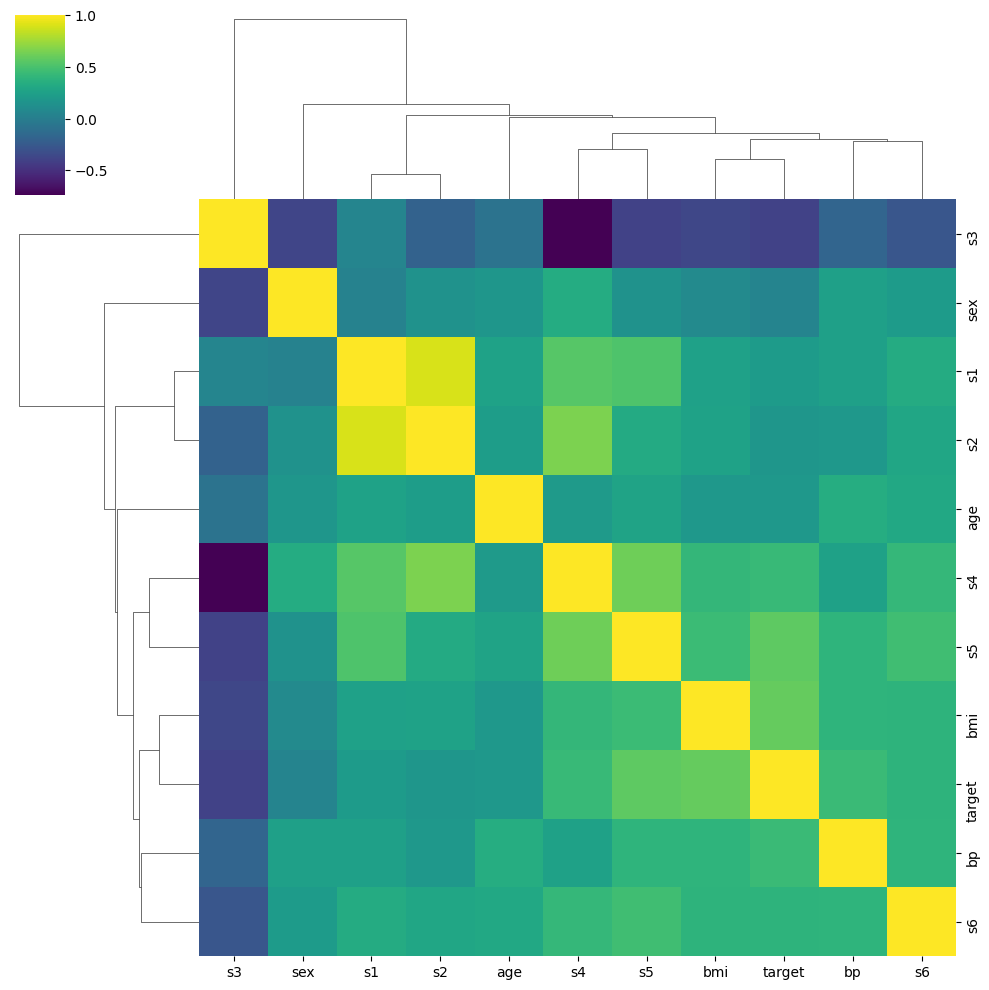

In [9]:
sns.clustermap(data.corr(), cmap='viridis')
plt.show()

There seem to be medium-strong correlations between our predictors, something to keep in mind for later when we will try to account for collinearities. Let's take a closer look at relations between our target and predictors.

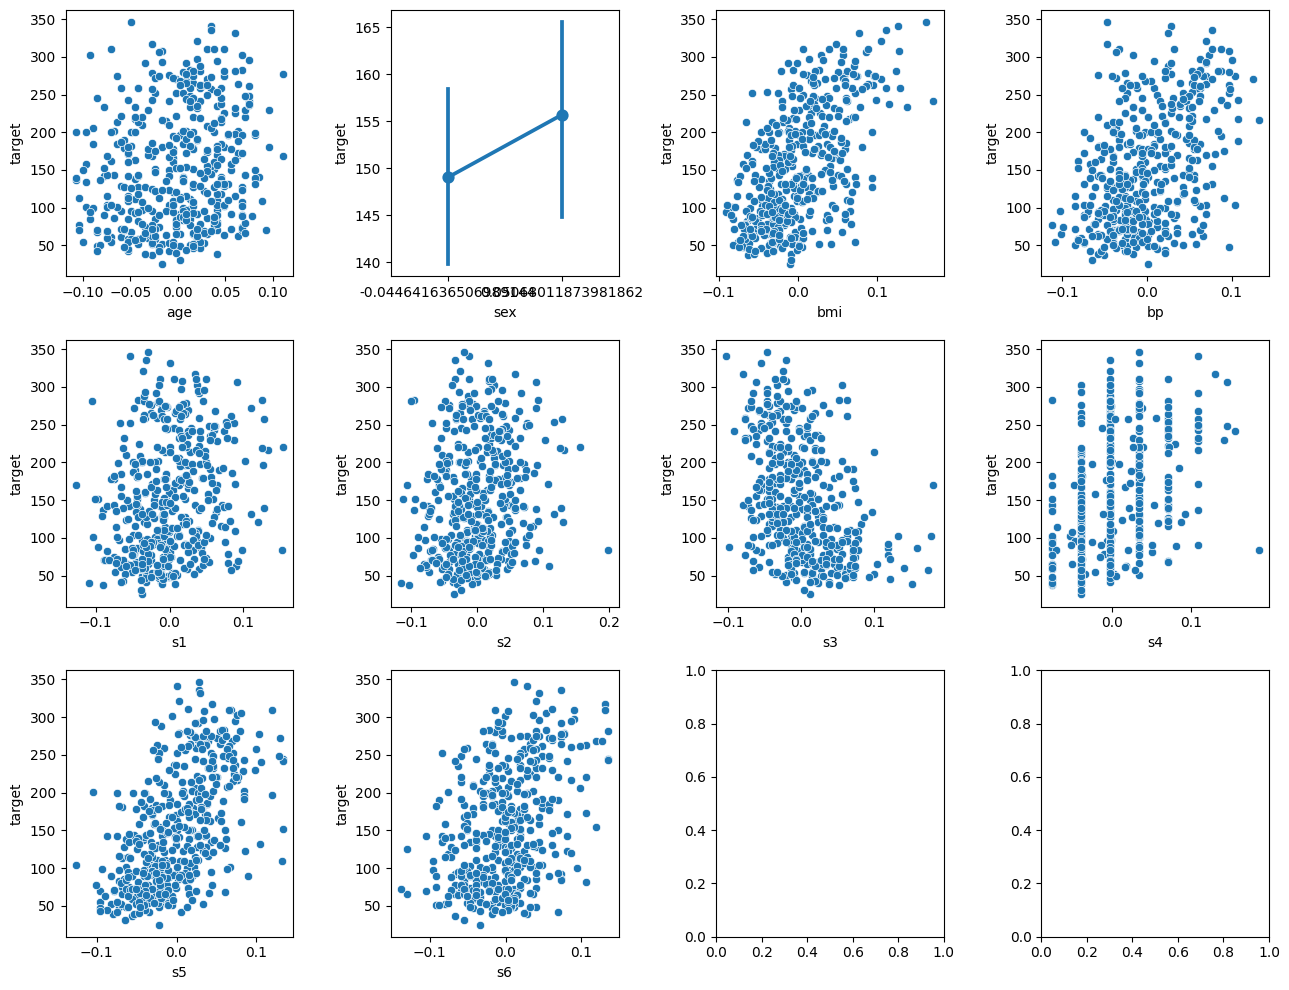

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(13,10))
plot_idx = list(itertools.product(range(3), range(4)))
for i,c in enumerate(data.columns):
    if c != 'target':
        if c == 'sex':
            sns.pointplot(data=data, x=c, y='target', ax=ax[plot_idx[i]])
        else:
            sns.scatterplot(data=data, x=c, y='target', ax=ax[plot_idx[i]])
plt.tight_layout()
plt.show()

### Choosing an evaluation metric

We are dealing with a regression problem where we care about knowing, in interpretable units, how off our predictions are. Big errors are kind of an issue here, so let's sacrifice some direct interpretability in favor of caution. We'll use RMSE.

### Train-dev-test split
Let's use scikit-learn's utils to create three data splits. First, we need to get our data to numpy arrays. This can be done easily in pandas. Note that we want to create 70/15/15 splits.

In [11]:
X = data.iloc[:,:10].values
y = data.iloc[:,10].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

Alright! Now let's save this data, so we can load it next time.

In [13]:
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = data.columns
    df.to_csv(f'example-data/{name}.csv')

OSError: Cannot save file into a non-existent directory: 'example-data'

### Let's start modeling!
One of the questions asked in the exercise is whether we want to transform the data. In our case, we might be okay with no transformation and we might want to retain interpretability of the output. Let's make this assumption, and work on non-transformed data.

### Our models
Let's define a few models we want to estimate:
- Model 0: predicting the mean of the training data
- Model 1: predicting the `target` based on age, sex, and BMI and blood pressure
- Model 2: predicting the target based on measurements.

For Model 2, we will fit both KNN and linear regression models.

First, let's create a list where we will store performance data, and compute the performance of our baseline

In [14]:
performances = []

In [15]:
mean_value = y_train.mean()
model_name = 'dummy'
for y,nsplit in zip([y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    performance = np.sqrt(mean_squared_error(y, 
                                             [mean_value]*y.shape[0]))
    r2 = r2_score(y, [mean_value]*y.shape[0])
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

Now let's fit a linear model with only demographic predictors

In [18]:
dem_cols = range(4)
reg = LinearRegression().fit(X_train[:,dem_cols], y_train)
pkl.dump(reg, file=open(f'example-models/linear-demographics.pkl', 'wb')) # save the model

In [19]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x[:,dem_cols])
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-demographics',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

And let's also see how a KNN model does!

In [20]:
for k in [3,5,10,20,30]:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train[:,dem_cols], y_train)
    pkl.dump(neigh, file=open(f'example-models/knn-demographics-{k}.pkl','wb')) # save the model
    for x,y,nsplit in zip([X_train, X_val, X_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
        preds = neigh.predict(x[:,dem_cols])
        r2 = r2_score(y, preds)
        performance = np.sqrt(mean_squared_error(y, preds))
        performances.append({'model': f'knn-demographics-{k}',
                            'split': nsplit,
                            'rmse': performance.round(4),
                            'r2': r2.round(4)})

### Full model
Finally, let's add all our predictors. First, linear models.

In [21]:
reg = LinearRegression().fit(X_train, y_train)
pkl.dump(reg, file=open(f'example-models/linear-allpreds.pkl', 'wb')) # save the model

Now let's evaluate them (note that the code down here just repeats what I have done before. I could have written a function, but I prefer keeping is longer but more explicit for now)

In [22]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-allpreds',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

And finally KNN models with all predictors

In [23]:
for k in [3,5,10,20,30]:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train, y_train)
    pkl.dump(neigh, file=open(f'example-models/knn-allpreds-{k}.pkl', 'wb')) # save the model
    for x,y,nsplit in zip([X_train, X_val, X_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
        preds = neigh.predict(x)
        r2 = r2_score(y, preds)
        performance = np.sqrt(mean_squared_error(y, preds))
        performances.append({'model': f'knn-allpreds-{k}',
                            'split': nsplit,
                            'rmse': performance.round(4),
                            'r2': r2.round(4)})

And finally, let's plot our performances.

In [24]:
perf_df = pd.DataFrame(performances)

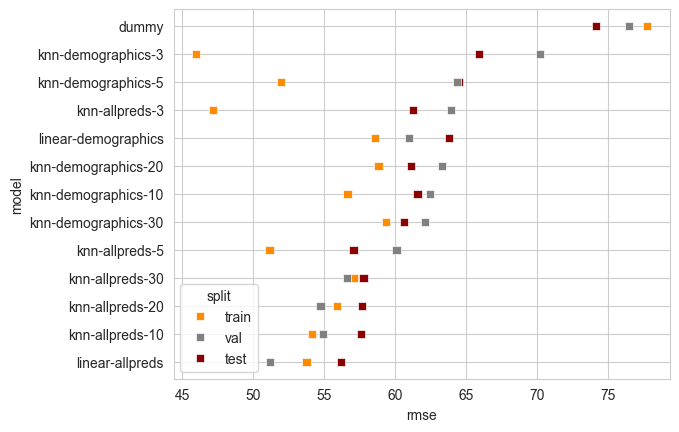

In [25]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

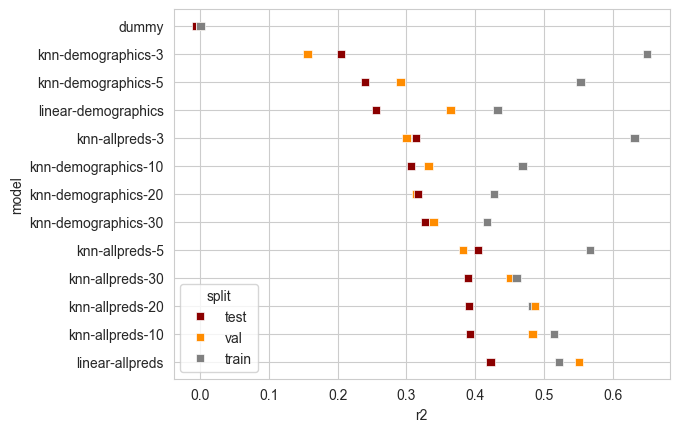

In [26]:
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=True), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkred', 'darkorange', 'grey'])
plt.show()

Our best model is the linear model including all predictors, which reduces the RMSE by more than 5 points! Let's also take a closer look at our predictions: let's load the best model, and see if there is any pattern on what it does wrong.

In [27]:
best_model = pkl.load(open('example-models/linear-allpreds.pkl', 'rb'))

In [28]:
best_preds = best_model.predict(X_val)
absolute_error = np.abs(best_preds - y_val)

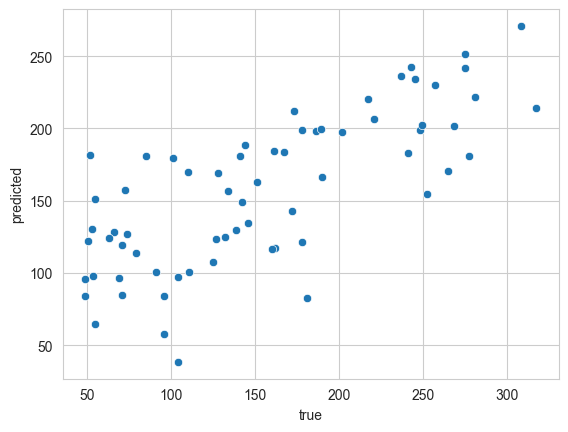

In [29]:
sns.scatterplot(x=y_val, y=best_preds)
plt.xlabel('true')
plt.ylabel('predicted')
plt.show()

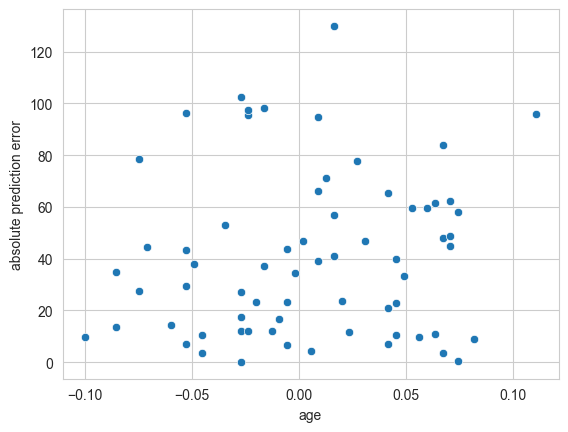

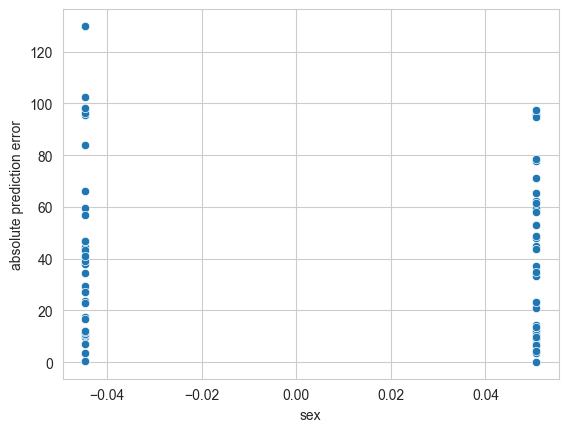

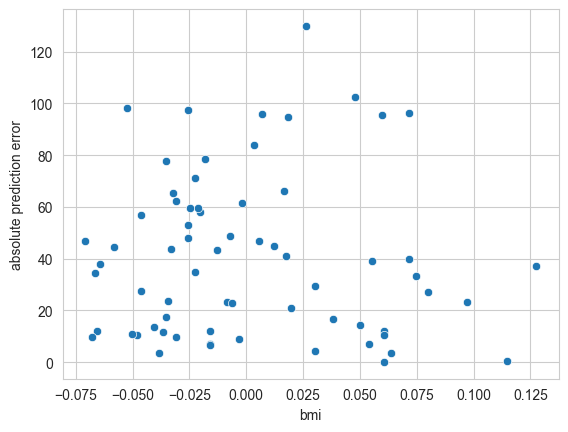

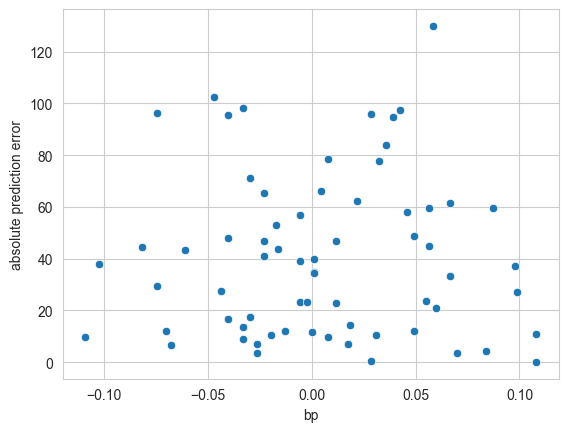

In [30]:
for i in range(4):
    sns.scatterplot(x=X_val[:,i], y=absolute_error)
    plt.xlabel(data.columns[i])
    plt.ylabel('absolute prediction error')
    plt.show()

There are no clear patterns in error types here, but for the sake of experience, let's try to add some polynomials and see how performance evolves!

### Adding polynomial features

In [31]:
from sklearn.preprocessing import PolynomialFeatures

for ionly in [True, False]:
    for deg in [2,3]:
        X_train_copy = X_train.copy()
        X_val_copy = X_val.copy()
        X_test_copy = X_test.copy()
        poly = PolynomialFeatures(deg, interaction_only=ionly)
        X_train_copy = poly.fit_transform(X_train_copy)
        X_val_copy = poly.fit_transform(X_val_copy)
        X_test_copy = poly.fit_transform(X_test_copy)
        reg = LinearRegression().fit(X_train_copy, y_train)
        for x,y,nsplit in zip([X_train_copy, 
                            X_val_copy, 
                            X_test_copy],
                            [y_train, y_val, y_test],
                            ['train', 'val', 'test']):
            preds = reg.predict(x)
            r2 = r2_score(y, preds)
            performance = np.sqrt(mean_squared_error(y, preds))
            performances.append({f'model': f'poly-allpreds-{deg}-intonly-{ionly}',
                                'split': nsplit,
                                'rmse': performance.round(4),
                                'r2': r2.round(4)})

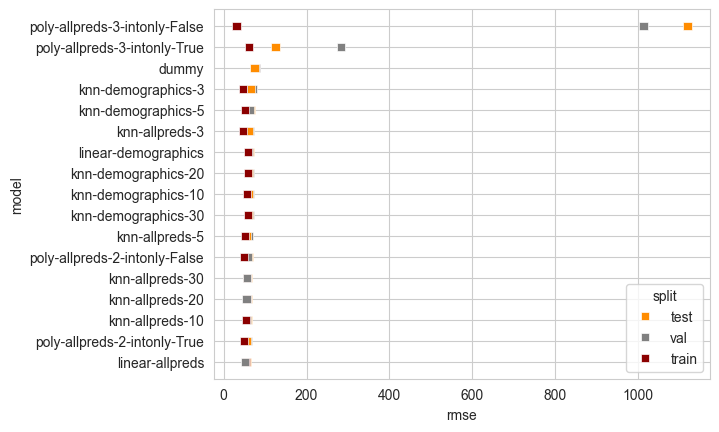

In [32]:
sns.set_style('whitegrid')
sns.scatterplot(data=pd.DataFrame(performances).sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

We don't see any clear performance advantage in adding polynomial features. So far, the model to beat is our linear model!